Importing required dependencies

In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pathlib
import PIL

from IPython.display import clear_output
import tensorflow as tf

%matplotlib inline

Important variables to be changed according to your preferences (or left alone)

In [2]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
VAL_SIZE = 800
OUTPUT_CHANNELS = 3
EPOCHS = 10
VAL_SPLITS=2
VALIDATION_STEPS = VAL_SIZE//BATCH_SIZE//VAL_SPLITS
image_size = (224,224)
folder = './COCOdataset2017'

Make a Tensorflow Dataset with the filenames of our dataset

In [3]:
data_dir = pathlib.Path('{}/images/train_img'.format(folder))
filenames = list(data_dir.glob('*.jpg'))
print("image count: ", len(filenames))

fnames=[]
for fname in filenames:
  fnames.append(str(fname))


data_dir = pathlib.Path('{}/images/train_mask'.format(folder))
filenames = list(data_dir.glob('*.jpg'))

fnames_mask=[]
for fname in filenames:
  fnames_mask.append(str(fname))

image count:  7406


In [4]:
STEPS_PER_EPOCH = len(filenames) // BATCH_SIZE

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((fnames, fnames_mask))

Splitting the training dataset into validation

In [6]:
training_dataset = train_dataset.skip(VAL_SIZE)
validation_dataset = train_dataset.take(VAL_SIZE)

Creating functions to read and convert filenames into images

In [7]:
def process_img(img):
  print("process_img acivated...")
  #color images
  img = tf.image.decode_jpeg(img) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  return img
  
def combine_train_images(file_path,file_path_mask):
  print("combine_images_labels acivated...")
  img = tf.io.read_file(file_path)
  mask = tf.io.read_file(file_path_mask)
  print("image file read...")
  img = process_img(img)
  mask = process_img(mask)
  #mask = tf.image.grayscale_to_rgb(mask)
  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)

  weights = tf.constant([6.0, 1.0, 1.0])

  sample_weights = tf.gather(weights, indices=tf.cast(mask, tf.int32))

  return img, mask, sample_weights

def combine_val_images(file_path,file_path_mask):
  print("combine_images_labels acivated...")
  img = tf.io.read_file(file_path)
  mask = tf.io.read_file(file_path_mask)
  print("image file read...")
  img = process_img(img)
  mask = process_img(mask)
  #mask = tf.image.grayscale_to_rgb(mask)
  return img, mask

"map" function will now map the filenames into the corresponding images

In [8]:
train_dataset=training_dataset.map(combine_train_images,num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = validation_dataset.map(combine_val_images,num_parallel_calls=tf.data.AUTOTUNE)

combine_images_labels acivated...
image file read...
process_img acivated...
process_img acivated...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
combine_images_labels acivated...
image file read...
process_img acivated...
process_img acivated...


In [9]:
training_dataset = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
training_dataset = training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = val_dataset.batch(BATCH_SIZE)

Now its time to define the model needed for image segmentation (U-net). Here I'm using MobileNetV2 as the decoder part of the model.

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   
    'block_3_expand_relu',  
    'block_6_expand_relu',  
    'block_13_expand_relu',  
    'block_16_project',      #8x8
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

Now to define the upsample block which consists of multiple layers

In [11]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [12]:
up_stack = [
    upsample(512, 3),  
    upsample(256, 3),  
    upsample(128, 3),  
    upsample(64, 3),   #112x112
]

Merging all the componenets defined above into a model

In [13]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #224x224

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Initializing and Compiling the model

In [14]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the model to see how it looks 

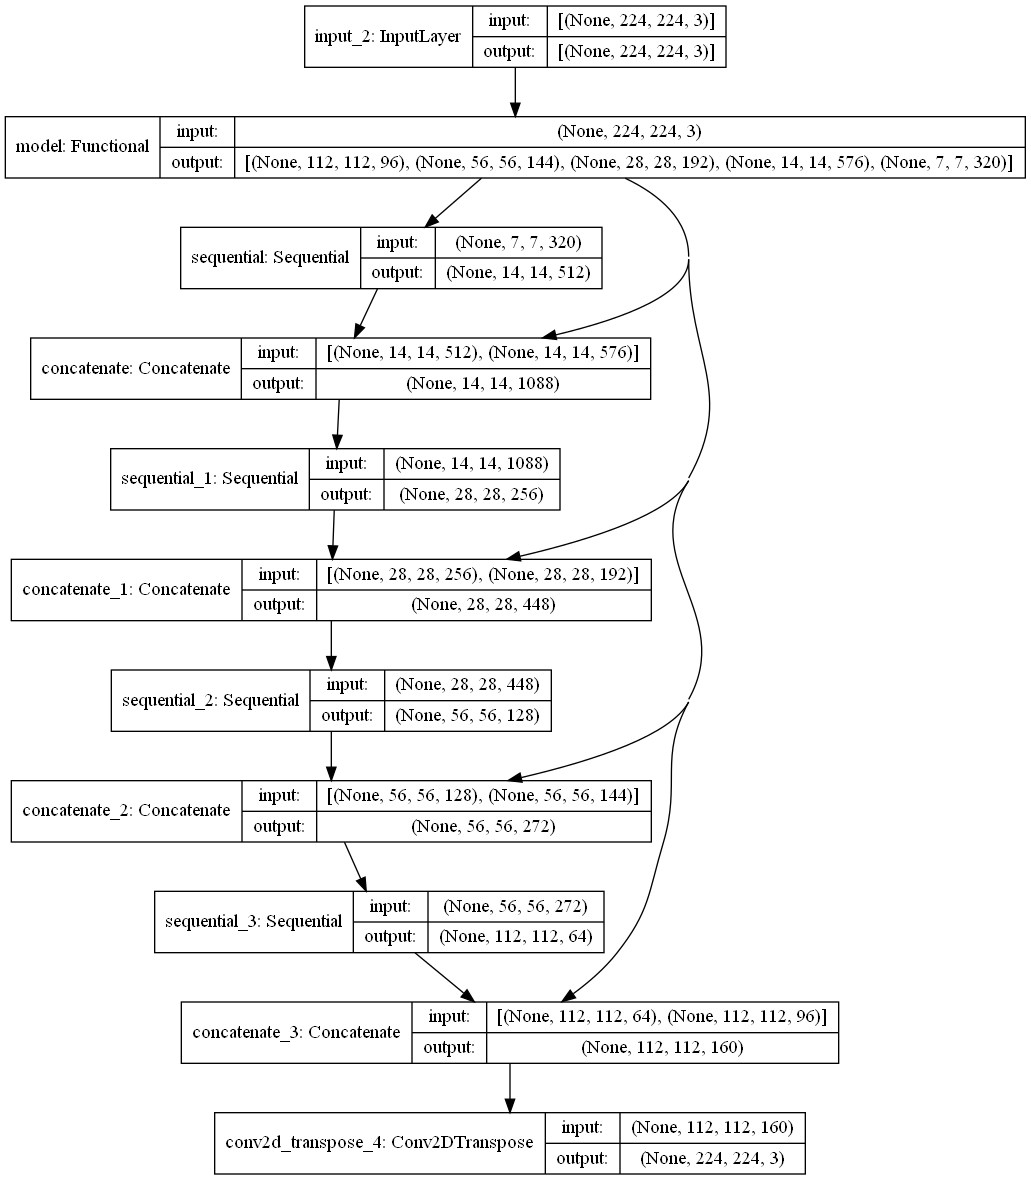

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

defining helper functions to manipulate and display images adn show predictions

In [16]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

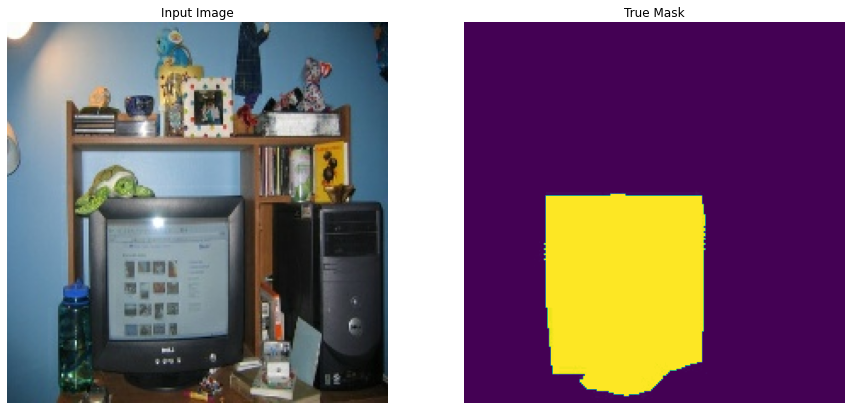

In [17]:
for image, mask in val_dataset.take(5):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=10):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

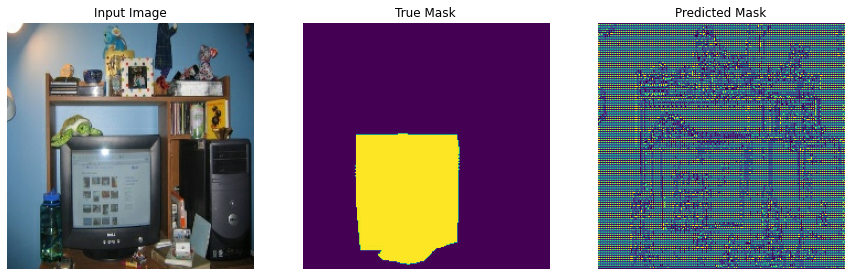

In [20]:
show_predictions()

A basic callback class to visualize the predictions after each epoch

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Training the model

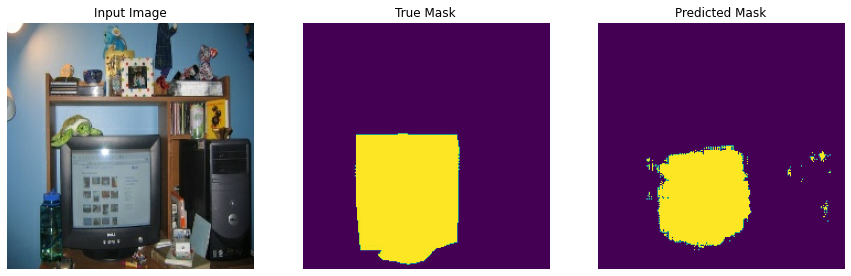


Sample Prediction after epoch 10



In [22]:
model_history = model.fit(training_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_dataset,
                          callbacks=[DisplayCallback()]
                          )

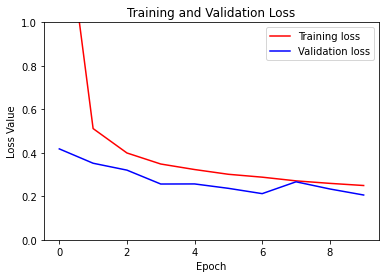

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

check the model's accuracy on validation dataset visually

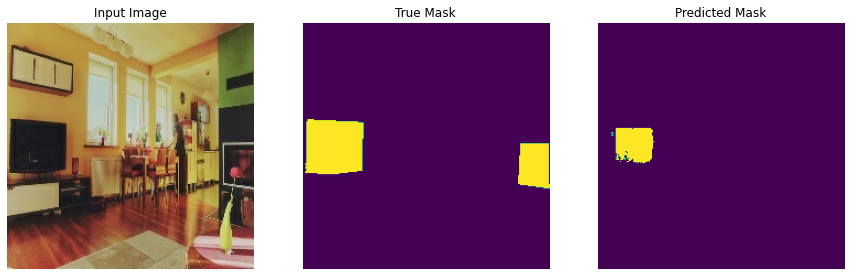

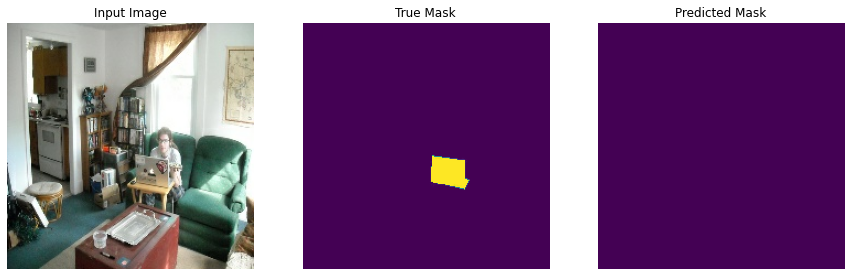

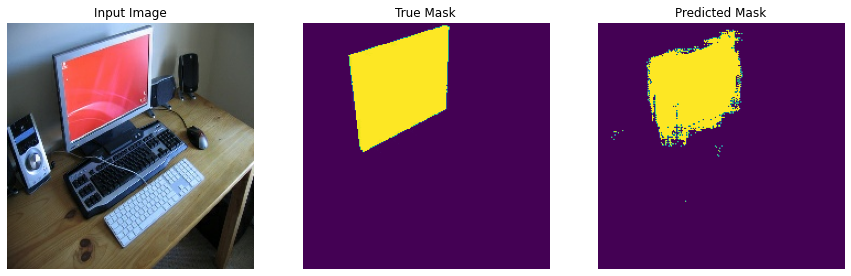

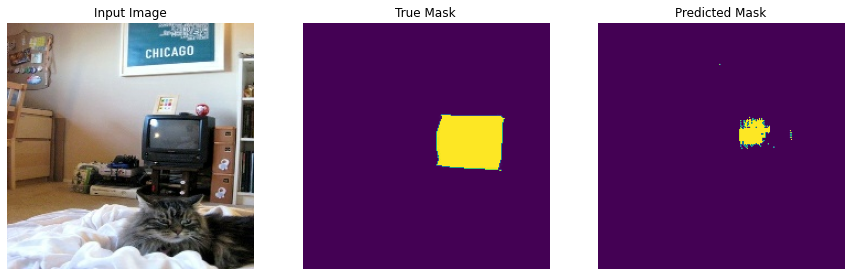

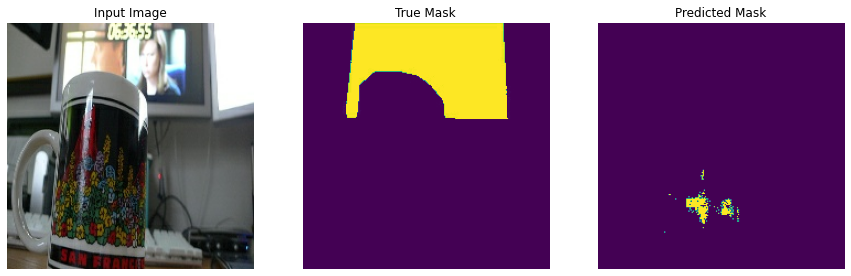

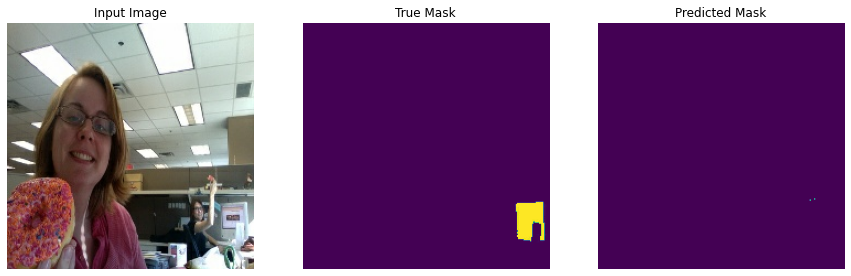

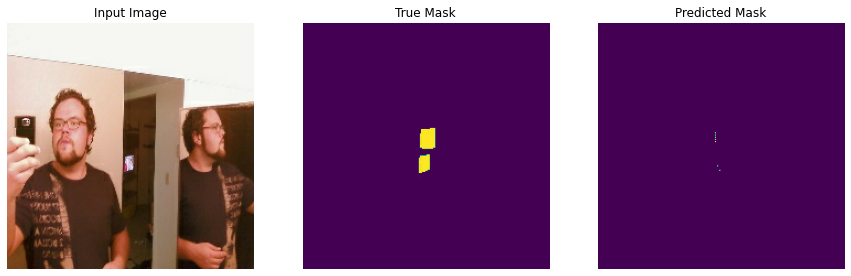

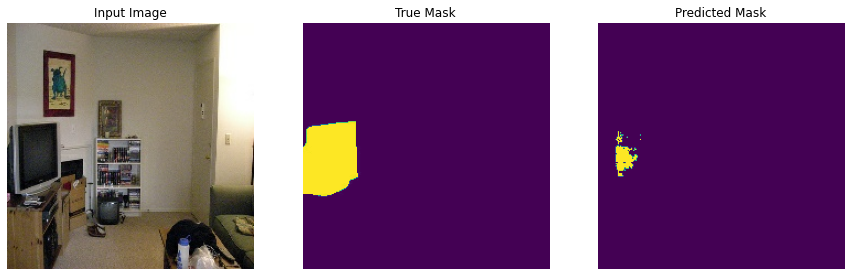

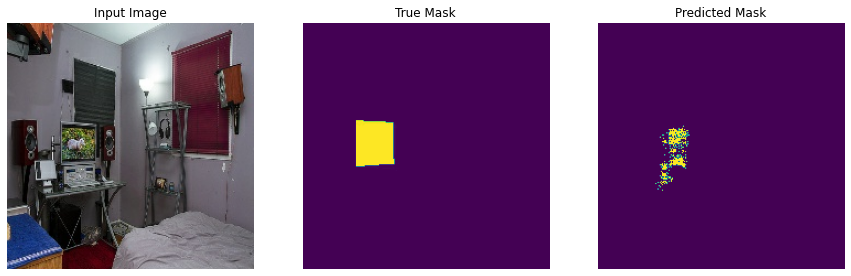

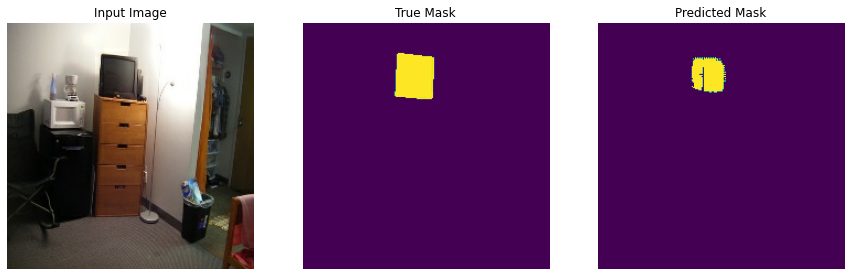

In [24]:
show_predictions(validation_dataset)

Finally edit a video to hide all the TVs and Laptops in the video (you can have your own video as the input and see the results)

In [32]:
output_size = (352,640)
cap = cv2.VideoCapture('vid1.mp4')
out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'mp4v'), 40, output_size)

while(cap.isOpened()):
    try:
        ret, frame = cap.read()
        cv2.imshow('frame', frame)
        frame = cv2.resize(frame,(224,224))
        img = tf.image.convert_image_dtype(frame[tf.newaxis, ...], tf.float32) 
        img = create_mask(model.predict(img))
        img = tf.keras.preprocessing.image.array_to_img(img)
        img = np.array(img.getchannel(0))
        img = cv2.GaussianBlur(img, (7, 7), 3)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        rect, img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

        background = cv2.bitwise_not(img)
        background = cv2.bitwise_and(frame, frame, mask=background)

        masked_img = cv2.bitwise_and(frame, frame, mask=img)
        masked_img = cv2.GaussianBlur(masked_img, (27, 27), 2)
        img = cv2.bitwise_or(masked_img, background)
        img = cv2.resize(img,output_size)
        cv2.imshow('imgage',img)
        out.write(img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except:
        break

cap.release()
cv2.destroyAllWindows()